In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.models import MultipleIndependentMFGP
from jaxbo.utils import normalize_MultifidelityGP, compute_w_gmm
from jaxbo.test_functions import *

from jax.scipy.stats import norm
import jaxbo.acquisitions as acquisitions

from jaxbo.input_priors import uniform_prior, gaussian_prior


from jaxbo.serializable import serializable_MF, deserializable_MF
import json 

onp.random.seed(1234)


In [2]:
# Example from 
# https://asmedigitalcollection.asme.org/mechanicaldesign/article/141/12/121001/975244?casa_token=45A-r7iV9IUAAAAA:ji-aHZ_T_HQ5Q1xgNxloqrG2LjOpFkXMItdWnuGH9d02MysONc3VTfrtM8GSB5oTdE2jcQ
# Section 4, and constraint in section 4.2 


def f_H(x):
    x1, x2 = x[0], x[1]
    a = 1.0
    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8*np.pi)
    f = a * (x2 - b*x1**2 + c*x1 -r)**2 + s * (1-t) * np.cos(x1) + s
    return f

def f_L(x):
    x1, x2 = x[0], x[1]
    f = 10*np.sqrt(f_H(x - 2)) + 2*(x1 - 2.5) - 3*(3*x2 - 7) - 1 # from the paper
    return f

def constraint_H(x):
    x1, x2 = (x[0]-2.5)/7.5, (x[1] - 7.5)/7.5
    g1 = (4 - 2.1*x1**2 + 1./3*x1**4)*x1**2 + x1*x2 + (-4+4*x2**2)*x2**2 + 3*np.sin(6*(1-x1)) + 3*np.sin(6*(1-x2))
    return g1 - 6.

def constraint_L(x):
    return constraint_H(x) * 0.8 + 0.5


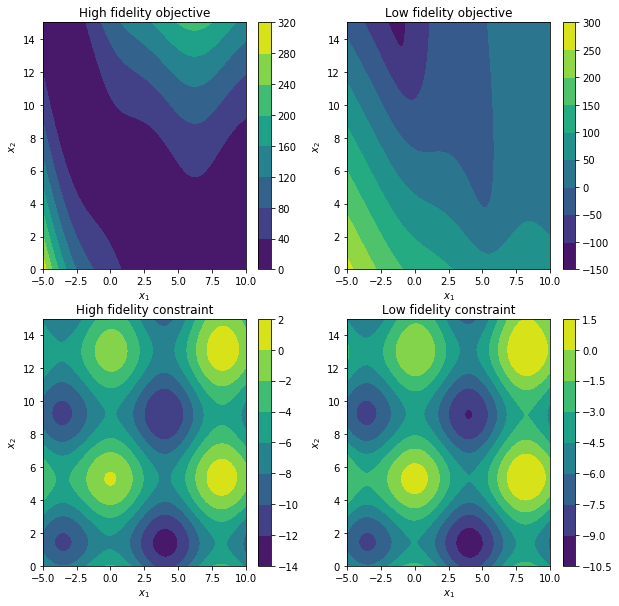

In [3]:
# Dimension of the problem
dim = 2

# Boundary of the domain
lb = np.array([-5.0, 0.0])
ub = np.array([10.0, 15.0])

bounds = {'lb': lb, 'ub': ub}

# Visualization of the function and constraints in 2D grid
nn = 100
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], 
                         YY.flatten()[:,None]], axis = 1)


y_f_H_star = vmap(f_H)(X_star)
y_f_L_star = vmap(f_L)(X_star)
y_c_H_star = vmap(constraint_H)(X_star)
y_c_L_star = vmap(constraint_L)(X_star)

Y_f_H_star = griddata(onp.array(X_star), onp.array(y_f_H_star), (onp.array(XX), onp.array(YY)), method='cubic')
Y_f_L_star = griddata(onp.array(X_star), onp.array(y_f_L_star), (onp.array(XX), onp.array(YY)), method='cubic')
Y_c_H_star = griddata(onp.array(X_star), onp.array(y_c_H_star), (onp.array(XX), onp.array(YY)), method='cubic')
Y_c_L_star = griddata(onp.array(X_star), onp.array(y_c_L_star), (onp.array(XX), onp.array(YY)), method='cubic')


plt.figure(figsize = (10, 10))
plt.subplot(2, 2, 1)
fig = plt.contourf(XX, YY, Y_f_H_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'High fidelity objective')
plt.colorbar(fig)

plt.subplot(2, 2, 2)
fig = plt.contourf(XX, YY, Y_f_L_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Low fidelity objective')
plt.colorbar(fig)

plt.subplot(2, 2, 3)
fig = plt.contourf(XX, YY, Y_c_H_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'High fidelity constraint')
plt.colorbar(fig)

plt.subplot(2, 2, 4)
fig = plt.contourf(XX, YY, Y_c_L_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Low fidelity constraint')
plt.colorbar(fig)



best y 7.710170184678906 best x [9.24242424 5.        ]


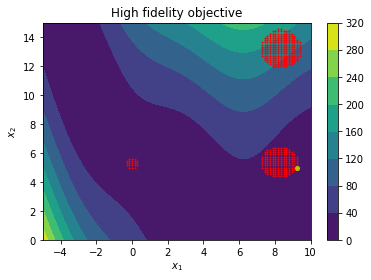

In [4]:
# Visualize the feasible domain and the location of the best value of this problem

judge1 = (y_c_H_star >= 0)

total_judge = judge1 

valid_index = np.where(total_judge)
#print(valid_index)

valid_x = X_star[valid_index]
valid_y = y_f_H_star[valid_index]

#print(valid_x.shape, valid_y.shape)
idx_best = np.argmin(valid_y)
x_best = valid_x[idx_best]
y_best = valid_y[idx_best]

plt.figure(figsize = (6,4))
fig = plt.contourf(XX, YY, Y_f_H_star)
plt.plot(valid_x[:,0], valid_x[:, 1], 'r.', markersize = 2.)
plt.plot(x_best[0], x_best[1], 'y.', markersize = 8.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'High fidelity objective')
plt.colorbar(fig)

print("best y", y_best, "best x", x_best)

true_x = x_best
true_y = y_best


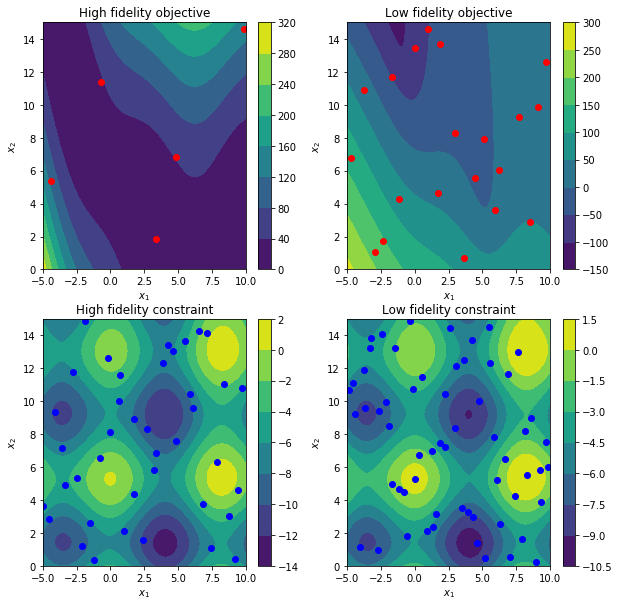

In [5]:
# Problem settings

# Number of initial data for objective and constraints
N_H_f = 5
N_H_c = 40
N_L_f = 20
N_L_c = 60

noise_f = 0.00
noise_c = 0.00

# Define prior distribution
p_x = uniform_prior(lb, ub)

# JAX-BO setting
options = {'kernel': 'RBF',
           'input_prior': p_x,
           'constrained_criterion': 'LW_LCBC',
           'criterion': 'US',
           'kappa': 2.0,
           'nIter': 10}


gp_model = MultipleIndependentMFGP(options)

# Domain bounds (already defined before where we visualized the data)
bounds = {'lb': lb, 'ub': ub}

# Initial training data for objectives
X_f_H = lb + (ub-lb)*lhs(dim, N_H_f)
y_f_H = vmap(f_H)(X_f_H)
y_f_H = y_f_H + noise_f*y_f_H_star.std(0)*onp.random.normal(0, 1, size=y_f_H.shape)


X_f_L = lb + (ub-lb)*lhs(dim, N_L_f)
y_f_L = vmap(f_L)(X_f_L)
y_f_L = y_f_L + noise_f*y_f_L_star.std(0)*onp.random.normal(0, 1, size=y_f_L.shape)


# Initial training data for constraints
X_c_H = lb + (ub-lb)*lhs(dim, N_H_c)
y_c_H = vmap(constraint_H)(X_c_H)
y_c_H = y_c_H + noise_c*y_c_H_star.std(0)*onp.random.normal(0, 1, size=y_c_H.shape)

X_c_L = lb + (ub-lb)*lhs(dim, N_L_c)
y_c_L = vmap(constraint_L)(X_c_L)
y_c_L = y_c_L + noise_c*y_c_L_star.std(0)*onp.random.normal(0, 1, size=y_c_L.shape)


# Visualize the initial data for objective and constraints
plt.figure(figsize = (10, 10))
plt.subplot(2, 2, 1)
fig = plt.contourf(XX, YY, Y_f_H_star)
plt.plot(X_f_H[:,0], X_f_H[:,1], 'ro', label = "Initial high fideilty objective data")
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'High fidelity objective')
plt.colorbar(fig)

plt.subplot(2, 2, 2)
fig = plt.contourf(XX, YY, Y_f_L_star)
plt.plot(X_f_L[:,0], X_f_L[:,1], 'ro', label = "Initial low fideilty objective data")
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Low fidelity objective')
plt.colorbar(fig)

plt.subplot(2, 2, 3)
fig = plt.contourf(XX, YY, Y_c_H_star)
plt.plot(X_c_H[:,0], X_c_H[:,1], 'bo', label = "Initial high fidelity constraint data")
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'High fidelity constraint')
plt.colorbar(fig)

plt.subplot(2, 2, 4)
fig = plt.contourf(XX, YY, Y_c_L_star)
plt.plot(X_c_L[:,0], X_c_L[:,1], 'bo', label = "Initial low fidelity constraint data")
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Low fidelity constraint')
plt.colorbar(fig)




In [6]:
f = open('/Users/yangyibo/Desktop/log.txt', "w")


# Main Bayesian optimization loop
rng_key = random.PRNGKey(0)
for it in range(options['nIter']):
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, options['nIter']))
    print('-------------------------------------------------------------------')


    # Fetch normalized training data (for objective and all the constraints)
    norm_batch_f, norm_const_f = normalize_MultifidelityGP(X_f_L, y_f_L, X_f_H, y_f_H, bounds)
    norm_batch_c, norm_const_c = normalize_MultifidelityGP(X_c_L, y_c_L, X_c_H, y_c_H, bounds)

    # Define a list using the normalized data and the normalizing constants
    norm_batch_list = [norm_batch_f, norm_batch_c]
    norm_const_list = [norm_const_f, norm_const_c]

    # Train GP model with 100 random restart
    print('Train GP...')
    rng_key = random.split(rng_key, 2)[0]
    opt_params_list = gp_model.train(norm_batch_list,
                                     rng_key,
                                     num_restarts = 10)

    # Fit GMM
    if options['constrained_criterion'] == 'LW_LCBC':
        print('Fit GMM...')
        rng_key = random.split(rng_key)[0]
        kwargs = {'params': opt_params_list,
                  'batch': norm_batch_list,
                  'norm_const': norm_const_list,
                  'bounds': bounds,
                  'rng_key': rng_key}
        gmm_vars = gp_model.fit_gmm(**kwargs, N_samples = 10000)
    else:
        gmm_vars = None


    # Find the next acquisition point with 50 random restart
    print('Computing next acquisition point (objective)...')
    kwargs = {'params': opt_params_list,
              'batch': norm_batch_list,
              'norm_const': norm_const_list,
              'bounds': bounds,
              'kappa': options['kappa'],
              'gmm_vars': gmm_vars,
              'rng_key': rng_key}
    # Acquire data
    new_X_f_H,_,_ = gp_model.constrained_compute_next_point_lbfgs(num_restarts=50, **kwargs)
    new_y_f_H = vmap(f_H)(new_X_f_H) # This is the output of the solver for generating the objective function
    new_y_f_H = new_y_f_H + noise_f*y_f_H_star.std(0)*onp.random.normal(new_y_f_H.shape)

    
    # Find the next acquisition point with 50 random restart
    print('Computing next acquisition point (constraint)...')
    kwargs = {'params': opt_params_list[-1],
              'batch': norm_batch_list[-1],
              'norm_const': norm_const_list[-1],
              'bounds': bounds,
              'rng_key': rng_key}
    # Acquire data
    new_X_c_H,_,_ = gp_model.compute_next_point_lbfgs(num_restarts=50, **kwargs)
    new_y_c_H = vmap(constraint_H)(new_X_c_H) # This is the output of the solver for generating the constraint1 functions
    new_y_c_H = new_y_c_H + noise_c*y_c_H_star.std(0)*onp.random.normal(new_y_c_H.shape)


    # # Augment training data
    print('Updating data-set...')
    X_f_H = np.concatenate([X_f_H, new_X_f_H], axis = 0)
    X_c_H = np.concatenate([X_c_H, new_X_c_H], axis = 0)

    y_f_H = np.concatenate([y_f_H, new_y_f_H], axis = 0)
    y_c_H = np.concatenate([y_c_H, new_y_c_H], axis = 0)


    # # Print current best
    print('True location: ({}), True value: {}'.format(true_x, true_y))
    print('New  location: ({}), New  value: {}'.format(new_X_f_H, new_y_f_H))

    X_c_L_list = [X_c_L]
    y_c_L_list = [y_c_L]
    X_c_H_list = [X_c_H]
    y_c_H_list = [y_c_H]
    
    return_dictionary = serializable_MF(opt_params_list, X_f_L, y_f_L, X_f_H, y_f_H, \
                                        X_c_L_list, y_c_L_list, X_c_H_list, y_c_H_list, bounds, gmm_vars)
    
    f.write(json.dumps(return_dictionary))
    f.write('\n')

    
f.close()


-------------------------------------------------------------------
------------------------- Iteration 1/10 -------------------------
-------------------------------------------------------------------
Train GP...
Fit GMM...
Computing next acquisition point (objective)...
Computing next acquisition point (constraint)...
Updating data-set...
True location: ([9.24242424 5.        ]), True value: 7.710170184678906
New  location: ([[ 8.13692051 13.38969145]]), New  value: [146.2471004]
-------------------------------------------------------------------
------------------------- Iteration 2/10 -------------------------
-------------------------------------------------------------------
Train GP...
Fit GMM...
Computing next acquisition point (objective)...
Computing next acquisition point (constraint)...
Updating data-set...
True location: ([9.24242424 5.        ]), True value: 7.710170184678906
New  location: ([[ 8.67192223 12.90742057]]), New  value: [123.86648558]
-----------------------

In [7]:
f = open('/Users/yangyibo/Desktop/log.txt')
#dict_read = json.loads(f.read())
s = f.read()

In [8]:
for ss in s.split('\n')[:-1]:
    return_dictionary = json.loads(ss)
    opt_params_list, X_f_L, y_f_L, X_f_H, y_f_H, \
            X_c_L_list, y_c_L_list, X_c_H_list, y_c_H_list, bounds, gmm_vars = deserializable_MF(return_dictionary)
    print(X_c_H_list[0].shape)
    

(41, 2)
(42, 2)
(43, 2)
(44, 2)
(45, 2)
(46, 2)
(47, 2)
(48, 2)
(49, 2)
(50, 2)


In [9]:
# Visualize the final outputs 

kwargs = {'params': opt_params_list,
          'batch': norm_batch_list,
          'norm_const': norm_const_list,
          'bounds': bounds,
          'kappa': gp_model.options['kappa'],
          'rng_key': rng_key,
          'gmm_vars': gmm_vars}

# Making prediction on the posterior objective and all constraints
mean, std = gp_model.predict_all(X_star, **kwargs)

mean = onp.array(mean)
std = onp.array(std)

mean[0:1,:] = mean[0:1,:] * norm_const_list[0]['sigma_y'] + norm_const_list[0]['mu_y']
std[0:1,:] = std[0:1,:] * norm_const_list[0]['sigma_y']


# Compute the weight
if options['constrained_criterion'] == 'LW_LCBC':
    w_pred = compute_w_gmm(X_star, **kwargs)
    

# Compute the upper and lower bounds of the posterior distributions
lower = mean - 2.0*std
upper = mean + 2.0*std

print(mean.shape, std.shape, lower.shape, upper.shape)


(2, 10000) (2, 10000) (2, 10000) (2, 10000)


In [10]:
# Evaluate the acquisition function
acq_fn1 = lambda x: gp_model.constrained_acquisition(x, **kwargs)
LW_LCBCacq = vmap(acq_fn1)(X_star)

# Compute the ratio and weights derived by the constraints and convert everything into numpy for plotting
ratio1 = mean[1,:] / std[1,:]

weight1 = norm.cdf(mean[1,:]/std[1,:])

LW_LCBCacq = onp.array(LW_LCBCacq)

mean = onp.array(mean)
std = onp.array(std)

ratio1 = onp.array(ratio1)

weight1 = onp.array(weight1)

y_f_H_pred = onp.array(mean[0,:])
y_c_H_pred = onp.array(mean[1,:])

y_f_H_std = onp.array(std[0,:])

try:
    w_pred = onp.array(w_pred)
except:
    w_pred = onp.ones_like(y_f_H_std)
    

kappa = 2.


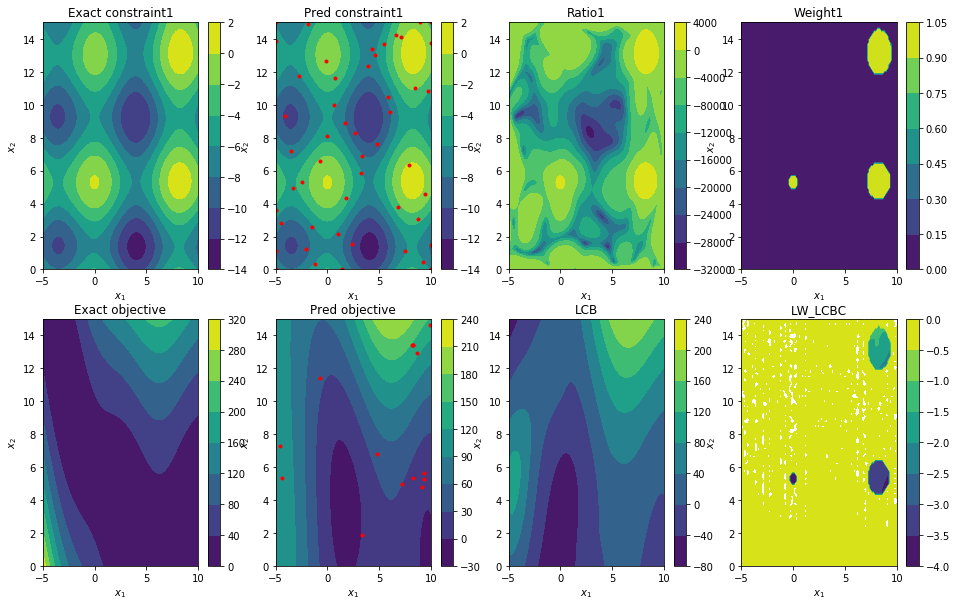

In [11]:
# Convert the numpy variable into grid data for visualization
Y_f_H_pred = griddata(onp.array(X_star), y_f_H_pred, (onp.array(XX), onp.array(YY)), method='cubic')
Y_c_H_pred = griddata(onp.array(X_star), y_c_H_pred, (onp.array(XX), onp.array(YY)), method='cubic')

Y_f_H_std = griddata(onp.array(X_star), y_f_H_std, (onp.array(XX), onp.array(YY)), method='cubic')

Ratio1 = griddata(onp.array(X_star), ratio1, (onp.array(XX), onp.array(YY)), method='cubic')

Weight1 = griddata(onp.array(X_star), weight1, (onp.array(XX), onp.array(YY)), method='cubic')

LW_LCBCacq = griddata(onp.array(X_star), LW_LCBCacq.flatten(), (onp.array(XX), onp.array(YY)), method='cubic')

W_pred = griddata(onp.array(X_star), w_pred.flatten(), (onp.array(XX), onp.array(YY)), method='cubic')



LCBacq = Y_f_H_pred - 3. - kappa*Y_f_H_std


# Visualization
plt.figure(figsize = (16,10))
plt.subplot(2, 4, 1)
fig = plt.contourf(XX, YY, Y_c_H_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact constraint1')
plt.colorbar(fig)

plt.subplot(2, 4, 2)
fig = plt.contourf(XX, YY, Y_c_H_pred)
plt.plot(X_c_H[:,0], X_c_H[:,1], 'r.')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Pred constraint1')
plt.colorbar(fig)

plt.subplot(2, 4, 3)
fig = plt.contourf(XX, YY, Ratio1)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Ratio1')
plt.colorbar(fig)


plt.subplot(2, 4, 4)
fig = plt.contourf(XX, YY, np.clip(Weight1, 0, np.inf))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Weight1')
plt.colorbar(fig)


plt.subplot(2, 4, 5)
fig = plt.contourf(XX, YY, Y_f_H_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact objective')
plt.colorbar(fig)

plt.subplot(2, 4, 6)
fig = plt.contourf(XX, YY, Y_f_H_pred)
plt.plot(X_f_H[:,0], X_f_H[:,1], 'r.')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Pred objective')
plt.colorbar(fig)

plt.subplot(2, 4, 7)
fig = plt.contourf(XX, YY, LCBacq)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'LCB')
plt.colorbar(fig)


plt.subplot(2, 4, 8)
fig = plt.contourf(XX, YY, LW_LCBCacq)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'LW_LCBC')
plt.colorbar(fig)





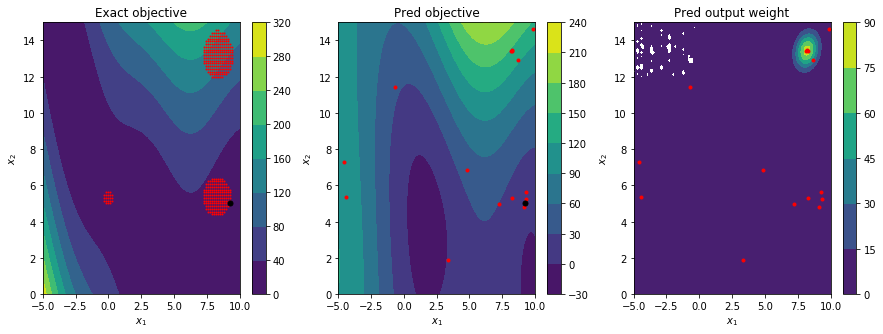

In [12]:


# Data we collected and the ground truth
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
fig = plt.contourf(XX, YY, Y_f_H_star)
plt.plot(valid_x[:,0], valid_x[:, 1], 'r.', markersize = 2.)
plt.plot(true_x[0], true_x[1], 'k.', markersize = 10.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact objective')
plt.colorbar(fig)


plt.subplot(1, 3, 2)
fig = plt.contourf(XX, YY, Y_f_H_pred)
plt.plot(X_f_H[:,0], X_f_H[:,1], 'r.')
plt.plot(true_x[0], true_x[1], 'k.', markersize = 10.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Pred objective')
plt.colorbar(fig)


plt.subplot(1, 3, 3)
fig = plt.contourf(XX, YY, W_pred)
plt.plot(X_f_H[:,0], X_f_H[:,1], 'r.')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Pred output weight')
plt.colorbar(fig)

